In [1]:
from tqdm import tqdm
from glob import glob
from matplotlib.colors import ListedColormap
from PixelClassification.utils.preprocess_data import extract_data, split_train_val, get_data_properties
from PixelClassification.utils.visualize import visualize_many_images, visualize
from PixelClassification.utils.create_dicts import create_dataset_dict, create_model_dict, create_configs, create_test_configs_dict
from PixelClassification.utils.generate_crops import *
from PixelClassification.train import begin_training
from PixelClassification.test import begin_evaluating
import tifffile, numpy as np, os, json, torch

%matplotlib inline

### Download data

>The images and corresponding masks are downloaded from an external url, specified by `zip_url` to the path specified by the variables `data_dir` and `project_name`, using `extract_data` function. 
Next, the `train` directories are split into `train` and `val` using `split_train_val`.

In [2]:
data_dir = '../../data'
project_name = 'dsb-2018'

In [3]:
extract_data(
    zip_url = 'https://github.com/juglab/EmbedSeg/releases/download/v0.1.0/dsb-2018.zip',
    data_dir = data_dir,
    project_name = project_name)

Created new directory ../../data
Downloaded data as ../../data/dsb-2018.zip
Unzipped data to ../../data/dsb-2018/download/


In [4]:
split_train_val(
    data_dir = data_dir,
    project_name = project_name, 
    train_val_name = 'train',
    subset = 0.15)

Created new directory : ../../data/dsb-2018/train/images/
Created new directory : ../../data/dsb-2018/train/masks/
Created new directory : ../../data/dsb-2018/val/images/
Created new directory : ../../data/dsb-2018/val/masks/
Created new directory : ../../data/dsb-2018/test/images/
Created new directory : ../../data/dsb-2018/test/masks/
Train-Val-Test Images/Masks copied to ../../data/dsb-2018


### Calculate the `minimum object size` from the training labels

>In the next cell, we will calculate the `min_object_size` and some other properties from the available train label masks

In [5]:
data_properties_dir = get_data_properties(data_dir, project_name, train_val_name=['train', 'val'], 
                                          test_name=['test'], mode='2d')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 447/447 [00:12<00:00, 35.13it/s]

Minimum object size of the `dsb-2018` dataset is equal to 21
Mean object size of the `dsb-2018` dataset is equal to 515.4253561841833
Maximum object size of the `dsb-2018` dataset is equal to 3513.3220000000147
Average object size of the `dsb-2018` dataset along `x` is equal to 22.736
Std. dev object size of the `dsb-2018` dataset along `x` is equal to 13.964
Average object size of the `dsb-2018` dataset along `y` is equal to 22.566
Std. dev object size of the `dsb-2018` dataset along `y` is equal to 14.002


In [6]:
min_object_size = int(data_properties_dir['min_object_size'])

In [7]:
min_object_size

21

<div class="alert alert-block alert-info"> <b>Any ideas on how one can use the `min_object_size` parameter for the purpose of segmentation?</b>

### Save crops of images and corresponding instance masks   

>Crops are saved at the location `crops_dir`. The `crop_size` is evaluated automatically from the available instance label masks

In [8]:
crops_dir = './crops'

In [9]:
n_sigma = 5
def round_up_8(x):
    return (x.astype(int)+7) & (-8)
crop_size = np.maximum(round_up_8(data_properties_dir['avg_object_size_y'] + n_sigma*data_properties_dir['stdev_object_size_y']),
round_up_8(data_properties_dir['avg_object_size_x'] + n_sigma*data_properties_dir['stdev_object_size_x']))
print("Crop size in x and y will be set equal to {}".format(crop_size))


Crop size in x and y will be set equal to 96


In [10]:
data_subsets = ['train', 'val'] 
for data_subset in data_subsets:
    image_dir = os.path.join(data_dir, project_name, data_subset, 'images')
    instance_dir = os.path.join(data_dir, project_name, data_subset, 'masks')
    image_names = sorted(glob(os.path.join(image_dir, '*.tif'))) 
    instance_names = sorted(glob(os.path.join(instance_dir, '*.tif')))  
    for i in tqdm(np.arange(len(image_names))):
        process(image_names[i], instance_names[i], os.path.join(crops_dir, project_name), data_subset, crop_size=crop_size)
    print("Cropping of images, instances and centre_images for data_subset = `{}` done!".format(data_subset))


  0%|                                                                                                                     | 0/380 [00:00<?, ?it/s]

Created new directory : ./crops/dsb-2018/train/images/
Created new directory : ./crops/dsb-2018/train/masks/


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [08:20<00:00,  1.32s/it]


Cropping of images, instances and centre_images for data_subset = `train` done!


  0%|                                                                                                                      | 0/67 [00:00<?, ?it/s]

Created new directory : ./crops/dsb-2018/val/images/
Created new directory : ./crops/dsb-2018/val/masks/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:27<00:00,  1.31s/it]

Cropping of images, instances and centre_images for data_subset = `val` done!


### Visualize images and their corresponding ground truth instance masks and semantic masks 

>Some of these images, their instance masks and the semantic masks are visualized.  
The instance masks are colored with a glasbey-style color map stored in `new_cmap`.

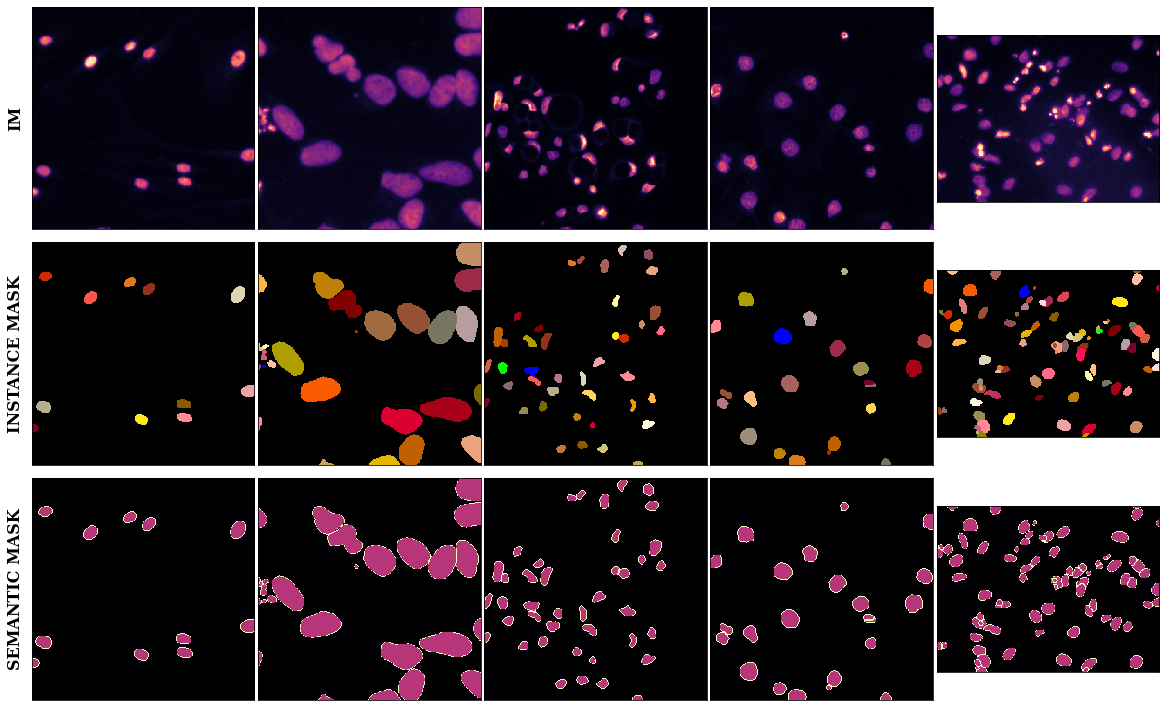

In [11]:
new_cmap = np.load('../../cmaps/cmap_60.npy')
new_cmap = ListedColormap(new_cmap) # new_cmap = 'magma' would also work! 
visualize_many_images(data_dir=data_dir, project_name=project_name, train_val_dir='val', n_images=5, new_cmp=new_cmap)

<div class="alert alert-block alert-info"> <b>Are the relative populations of pixels per class the same? Can you quantify this by looping over the training instance masks? </b> <br>
In case one class is more dominant than the other (i..e class imbalance), how can we counteract this during the training? </div>

Class imbalance can be counteracted by weighting the importance of less present classes.

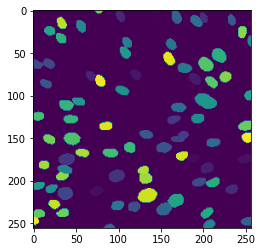

In [79]:
from tifffile import imread
from collections import Counter
import matplotlib.pyplot as plt

basedir = os.path.join(data_dir,'dsb-2018','train','masks')
mask_files = [os.path.join(basedir,x) for x in os.listdir(basedir)]

for mask in mask_files[0:1]: # Just for one, but can see that 0 is present abundantly
     img = imread(mask)
     plt.imshow(img)
     counts = Counter(img.flatten())
     props = {k:v/img.flatten().shape[0] * 100 for k,v in counts.items()}

In [80]:
props

{0: 82.97882080078125,
 66: 0.04730224609375,
 1: 0.048828125,
 26: 0.225830078125,
 9: 0.164794921875,
 11: 0.13580322265625,
 24: 0.1434326171875,
 31: 0.213623046875,
 74: 0.18768310546875,
 39: 0.1983642578125,
 49: 0.1739501953125,
 68: 0.1861572265625,
 53: 0.18157958984375,
 38: 0.06256103515625,
 35: 0.16632080078125,
 32: 0.1922607421875,
 45: 0.20599365234375,
 52: 0.33721923828125,
 79: 0.244140625,
 60: 0.347900390625,
 18: 0.34332275390625,
 34: 0.238037109375,
 5: 0.1861572265625,
 8: 0.15869140625,
 67: 0.21820068359375,
 6: 0.2288818359375,
 81: 0.1983642578125,
 61: 0.21820068359375,
 22: 0.17242431640625,
 42: 0.20294189453125,
 47: 0.115966796875,
 43: 0.51116943359375,
 44: 0.17547607421875,
 54: 0.25634765625,
 30: 0.2349853515625,
 58: 0.17547607421875,
 40: 0.2166748046875,
 55: 0.21209716796875,
 14: 0.18157958984375,
 63: 0.22430419921875,
 78: 0.1953125,
 23: 0.19683837890625,
 15: 0.12664794921875,
 59: 0.3387451171875,
 82: 0.16937255859375,
 65: 0.192260742

### Specify training dataset-related parameters

>We create a `train_dataset_dict` dictionary using the crops extracted from the train images and masks 

In [32]:
train_dataset_dict = create_dataset_dict(data_dir = crops_dir,  
                                         project_name = project_name,  
                                         size = len(os.listdir(os.path.join(crops_dir, project_name, 'train', 'images'))), 
                                         batch_size = 16, 
                                         type = 'train')

`train_dataset_dict` dictionary successfully created with: 
 -- train images accessed from ./crops/dsb-2018/train/images, 
 -- number of images per epoch equal to 16301, 
 -- batch size set at 16, 


### Specify validation dataset-related parameters

>We create a `val_dataset_dict` dictionary using the crops extracted from the validation images and masks 

In [33]:
val_dataset_dict = create_dataset_dict(data_dir = crops_dir, 
                                       project_name = project_name, 
                                       size = len(os.listdir(os.path.join(crops_dir, project_name, 'val', 'images'))), 
                                       batch_size = 16, 
                                       type ='val')

`val_dataset_dict` dictionary successfully created with: 
 -- val images accessed from ./crops/dsb-2018/val/images, 
 -- number of images per epoch equal to 3069, 
 -- batch size set at 16, 


### Specify model-related parameters

>In the cell after this one, a `model_dataset_dict` dictionary is created.  
Number of classes is set to `3` by default, where the first class is background, second class is foreground (interior of a cell or nucleus) and third class is the membrane.

In [34]:
model_dict = create_model_dict()

`model_dict` dictionary successfully created with: 
 -- num of classes equal to 3, 
 -- name equal to unet


In [36]:
model_dict

{'name': 'unet', 'kwargs': {'num_classes': 3, 'depth': 3, 'in_channels': 1}}

<div class="alert alert-block alert-info"> <b>Which other parameters can we set while initializing the model? </b>  <br>
For example, what is the default depth of the `U-Net` model? 
What would the benefit/disadvantage of increasing the `depth` of the model? 
Which other parameters are of interest? 

</div> 

### Specify the duration of training by setting `n_epochs`

>In the cell after this one, a `configs` dictionary is created.  
The model weights are saved by default at `experiment/dsb-2018-demo`

In [37]:
n_epochs = 10

In [38]:
configs = create_configs(save_dir = os.path.join('experiment', project_name+'-'+'demo'), 
                         n_epochs=n_epochs,
                         resume_path=None, 
                         )

`configs` dictionary successfully created with: 
 -- n_epochs equal to 10, 
 -- save_dir equal to experiment/dsb-2018-demo, 


### Begin training!

>We input the dictionaries created above to the `begin_training` function.  

In [39]:
%matplotlib Agg
begin_training(train_dataset_dict, val_dataset_dict, model_dict, configs)

2D `train` Dataset created.
2D `val` Dataset created.
Initializing a U-Net with depth = 3, in-channels = 1 and num_classes = 3.
Created logger with keys:  ('train', 'val', 'ap')
Starting epoch 0
learning rate: 0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:23<00:00,  8.04it/s]

===> train loss: 0.27
===> val loss: 0.24, val ap: 0.73


=> saving checkpoint
Starting epoch 1
learning rate: 0.0004977494364660346


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:25<00:00,  7.57it/s]

===> train loss: 0.24
===> val loss: 0.22, val ap: 0.77
=> saving checkpoint


Starting epoch 2
learning rate: 0.0004954977417064171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:22<00:00,  8.46it/s]

===> train loss: 0.23
===> val loss: 0.22, val ap: 0.79


=> saving checkpoint
Starting epoch 3
learning rate: 0.0004932449094349202


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:26<00:00,  7.21it/s]

===> train loss: 0.22
===> val loss: 0.20, val ap: 0.80
=> saving checkpoint


Starting epoch 4
learning rate: 0.0004909909332982877


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:18<00:00, 10.18it/s]

===> train loss: 0.22
===> val loss: 0.21, val ap: 0.82


=> saving checkpoint
Starting epoch 5
learning rate: 0.0004887358068751748


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:21<00:00,  9.04it/s]

===> train loss: 0.22
===> val loss: 0.21, val ap: 0.79
=> saving checkpoint


Starting epoch 6
learning rate: 0.0004864795236750653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:19<00:00,  9.58it/s]

===> train loss: 0.22
===> val loss: 0.21, val ap: 0.80
=> saving checkpoint


Starting epoch 7
learning rate: 0.00048422207713716544


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:20<00:00,  9.51it/s]

===> train loss: 0.22
===> val loss: 0.20, val ap: 0.81
=> saving checkpoint


Starting epoch 8
learning rate: 0.00048196346062927547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:19<00:00,  9.57it/s]

===> train loss: 0.22
===> val loss: 0.20, val ap: 0.81
=> saving checkpoint


Starting epoch 9
learning rate: 0.00047970366744663594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:23<00:00,  8.23it/s]

===> train loss: 0.21
===> val loss: 0.20, val ap: 0.82


=> saving checkpoint


<div class="alert alert-block alert-info"> <b> How is the best model state decided? </b><br>  
    What is the <i>ap</i> value, which is printed at the end of each epoch?</div>
This should refer to the Average Precision, a common metric used in document and image classification tasks, the best model state should be the one with lowest loss and highest AP. As a trend it is possible to see how as loss goes down, AP rises.

<div class="alert alert-block alert-info"> <b> Investigate whether the loss curve (<i>examples/DL4MIA/experiment/dsb-2018-demo/loss.png</i>) has flattened out.</b>  <br>
Do you think <u>longer</u> training benefit?  </div>  


### Infer using your model weights 

> The training phase is over for now.  
Let's use the model trained by you above for $5$ epochs to infer on unseen images, next.

In [40]:
checkpoint_path = os.path.join('experiment', project_name+'-'+'demo', 'best_iou_model.pth')

### Specify where results should be saved during  inference

>We set the location where the predictions of the test images are saved with `save_dir`.  
In the cell after this one, a `test_configs` dictionary is created.

In [41]:
save_dir = './inference/' + project_name

In [42]:
test_configs = create_test_configs_dict(data_dir = os.path.join(data_dir, project_name),
                                        checkpoint_path = checkpoint_path,
                                        min_object_size = min_object_size, 
                                        save_dir = save_dir,
                                        )

`test_configs` dictionary successfully created with: 
 -- evaluation images accessed from ../../data/dsb-2018, 
 -- trained weights accessed from experiment/dsb-2018-demo/best_iou_model.pth, 
 -- output directory chosen as ./inference/dsb-2018


<div class="alert alert-block alert-info">
    Investigate the <b>test_configs</b> dictionary
</div>    

In [43]:
test_configs

{'ap_val': 0.5,
 'min_object_size': 21,
 'cuda': True,
 'save_results': True,
 'save_images': True,
 'save_dir': './inference/dsb-2018',
 'checkpoint_path': 'experiment/dsb-2018-demo/best_iou_model.pth',
 'name': '2d',
 'dataset': {'name': '2d',
  'kwargs': {'data_dir': '../../data/dsb-2018',
   'type': 'test',
   'transform': Compose(
   )}},
 'model': {'name': 'unet', 'kwargs': {'num_classes': 3}}}

### Evaluate on unseen test data

>The `test_configs` dictionary created above, is input to the `begin_evaluating` function.

In [44]:
%matplotlib inline
result = begin_evaluating(test_configs)

2D `test` Dataset created.
Initializing a U-Net with depth = 3, in-channels = 1 and num_classes = 3.


  8%|████████▊                                                                                                     | 4/50 [00:01<00:11,  3.95it/s]

Created new directory ./inference/dsb-2018/predictions/
Created new directory ./inference/dsb-2018/ground-truth/
Created new directory ./inference/dsb-2018/seeds/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  8.08it/s]

Mean Result (Accuracy) is 0.8234744886198428


In [45]:
%matplotlib inline
prediction_file_names = sorted(glob(os.path.join(save_dir,'predictions','*.tif')))
ground_truth_file_names = sorted(glob(os.path.join(save_dir,'ground-truth','*.tif')))
seed_file_names = sorted(glob(os.path.join(save_dir,'seeds','*.tif')))
image_file_names = sorted(glob(os.path.join(data_dir, project_name, 'test', 'images','*.tif')))

### Visualize some results on unseen test data

>Change value of `index` to see predictions on different unseen, test images.

Image filename is 0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0.tif and index is 1


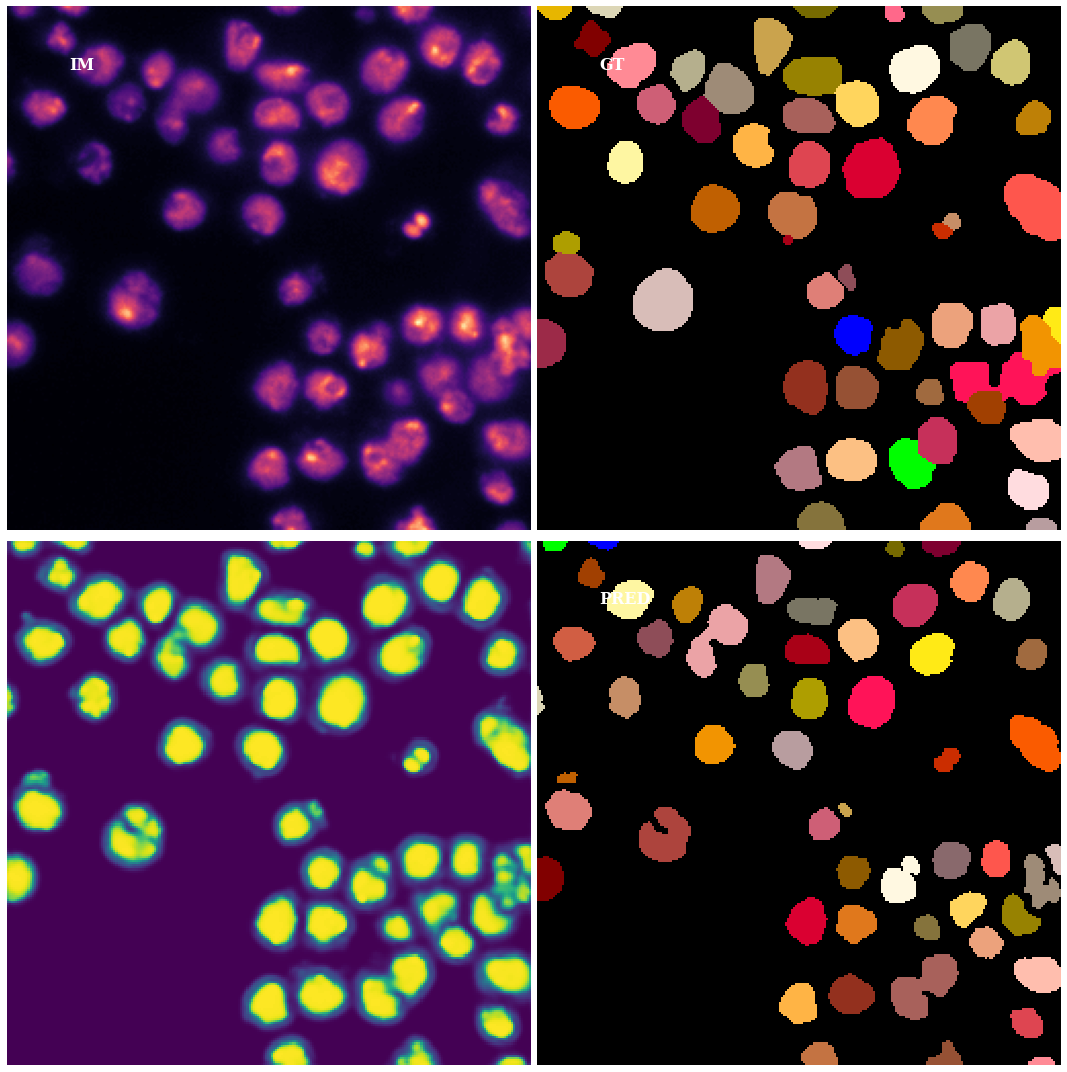

In [47]:
index = 1
print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
prediction = tifffile.imread(prediction_file_names[index])
image = tifffile.imread(image_file_names[index])
seed = tifffile.imread(seed_file_names[index])
if len(ground_truth_file_names) > 0:
    ground_truth = tifffile.imread(ground_truth_file_names[index])
    visualize(image = image, prediction = prediction, ground_truth = ground_truth, seed = seed, new_cmp = new_cmap)
else:
    visualize(image = image, prediction = prediction, ground_truth = None, seed = seed, new_cmp = new_cmap)

<div class="alert alert-block alert-info">
Look at some predictions by changing the <i>index</i> variable in the cell above. <br> 
What errors do you commonly see in the predictions?
</div>    
Cells mainly get classified as single blobs and/or cells are not recognized.